In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
 # Importing dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, ConfusionMatrixDisplay
from scipy import stats
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import accuracy_score
SEED=30

# Load the dataset
data = pd.read_csv('/content/dataset_phishing.csv')

# Define class labels
classes = {0: 'phishing', 1: 'legitimate'}


In [ ]:
from sklearn.utils import resample

# Separate classes
phishing = data[data['status'] == 'phishing']
legitimate = data[data['status'] == 'legitimate']

# Downsample legitimate
legitimate_downsampled = resample(legitimate,
                                replace=False,    # without replacement
                                n_samples=len(phishing),  # match minority
                                random_state=SEED)

# Combine
data_balanced = pd.concat([phishing, legitimate_downsampled])


In [ ]:
phishing_upsampled = resample(phishing,
                             replace=True,     # with replacement
                             n_samples=len(legitimate),  # match majority
                             random_state=SEED)

data_balanced = pd.concat([phishing_upsampled, legitimate])


In [ ]:
data.isnull().sum()[data.isnull().sum() > 0]

,0


In [ ]:
# Separate features and target variable
X = data.drop('status', axis=1)
y = data['status']

In [ ]:
# Separate features and target variable
X = data.drop('status', axis=1)
y = data['status']

# Remove rows with NaN values in the target variable
X = X[~y.isnull()]  # Keep rows in X where y is not null
y = y[~y.isnull()]  # Keep rows in y where y is not null

# Convert the target variable 'y' to a numerical type (0 for 'phishing', 1 for 'legitimate')
# This is required for calculating point-biserial correlation which expects numerical inputs.
y_numeric = y.map({'phishing': 0, 'legitimate': 1})

# --- Check and handle non-numeric columns in X ---
print("Data types of X columns before conversion:")
print(X.dtypes)

# Identify non-numeric columns (excluding 'object' which might hold numbers as strings, handle carefully)
# Let's focus on converting columns that *should* be numeric but might be 'object'
# A common cause is mixed types or string representations of numbers
for col in X.columns:
    # Attempt to convert to numeric, forcing errors to NaN
    X[col] = pd.to_numeric(X[col], errors='coerce')

# After conversion, check for any columns that are still non-numeric (like object or category if not handled)
# Or check for columns that are now all NaN if conversion failed
non_numeric_cols_after = X.select_dtypes(exclude=np.number).columns
if len(non_numeric_cols_after) > 0:
    print("\nNon-numeric columns remaining after attempted conversion:")
    print(non_numeric_cols_after)
    # You might need to drop these columns if they cannot be converted
    # X = X.drop(columns=non_numeric_cols_after)
    # Or handle NaNs introduced by 'coerce' depending on your strategy
    # X = X.fillna(X.mean()) # Example: fill NaNs with mean

# For point-biserial correlation, ensure no infinite values either
X = X.replace([np.inf, -np.inf], np.nan)
# Handle any remaining NaNs, e.g., by dropping rows or filling
# Dropping rows might remove data points where y is also non-numeric, which is already handled above.
# Let's fill with 0 or mean, assuming NaNs should not exist after cleaning
X = X.fillna(0) # Or use X.mean()

print("\nData types of X columns after handling:")
print(X.dtypes)
# --- End of handling non-numeric columns ---


# Calculate feature importance using Mutual Information and Point-Biserial correlation
point_biserial_coefs = []
# Iterate through columns of X, ensuring they are numeric
for i in range(X.shape[1]):
    col_data = X.iloc[:, i]

    # Ensure the column data is numerical and does not contain only identical values
    # pointbiserialr requires variation in the numeric variable
    if pd.api.types.is_numeric_dtype(col_data) and col_data.nunique() > 1:
        try:
            # Use the numerical version of y for point-biserial correlation
            coef = stats.pointbiserialr(col_data, y_numeric)[0]
            point_biserial_coefs.append(coef)
        except ValueError as e:
            print(f"Could not calculate point-biserial correlation for column {X.columns[i]} due to error: {e}")
            point_biserial_coefs.append(np.nan) # Append NaN or 0 if calculation fails
    else:
        print(f"Skipping column {X.columns[i]} for point-biserial correlation (not numeric or constant value).")
        point_biserial_coefs.append(np.nan) # Append NaN for non-applicable columns


# Mutual information can handle categorical target variables, so we use the original y
# Ensure X only contains numerical or suitable categorical data for mutual_info_classif
# mutual_info_classif works with numerical, boolean, or discrete (integer) data.
# Convert any remaining 'object' columns that represent categories to category dtype or one-hot encode if necessary for mutual_info_classif
# For this dataset, the initial check suggests features are intended to be numeric.
# If after pd.to_numeric, there are still object columns, you might need to drop them
X_for_mi = X.select_dtypes(include=np.number) # Select only numerical columns for mutual information

if not X_for_mi.empty:
    # Align columns for mutual_info_classif with point_biserial_coefs list
    # This requires careful indexing or ensuring both calculations are done on the same set of columns.
    # Let's re-calculate mutual_inf only for the columns we attempted point-biserial on
    mutual_inf = []
    for i in range(X.shape[1]):
        col_data = X.iloc[:, i]
        if pd.api.types.is_numeric_dtype(col_data) and col_data.nunique() > 1:
             # mutual_info_classif expects a 2D array-like for X
             try:
                 mi_score = mutual_info_classif(col_data.values.reshape(-1, 1), y)
                 mutual_inf.append(mi_score[0])
             except ValueError as e:
                 print(f"Could not calculate mutual information for column {X.columns[i]} due to error: {e}")
                 mutual_inf.append(np.nan)
        else:
            mutual_inf.append(np.nan) # Append NaN for non-applicable columns

else:
    print("No numerical columns available for mutual information calculation.")
    mutual_inf = [np.nan] * X.shape[1]


# Create a DataFrame to store feature importance
# Only include columns for which both calculations were attempted (or use a combined list of valid columns)
# Let's align the results based on the original X.columns
feature_importance = pd.DataFrame({'Mutual Inf': mutual_inf, 'Point-BiSerial': point_biserial_coefs}, index=X.columns)

Data types of X columns before conversion:
url                object
length_url          int64
length_hostname     int64
ip                  int64
nb_dots             int64
                    ...  
domain_age          int64
web_traffic         int64
dns_record          int64
google_index        int64
page_rank           int64
Length: 88, dtype: object

Data types of X columns after handling:
url                float64
length_url           int64
length_hostname      int64
ip                   int64
nb_dots              int64
                    ...   
domain_age           int64
web_traffic          int64
dns_record           int64
google_index         int64
page_rank            int64
Length: 88, dtype: object
Skipping column url for point-biserial correlation (not numeric or constant value).
Skipping column nb_or for point-biserial correlation (not numeric or constant value).
Skipping column ratio_nullHyperlinks for point-biserial correlation (not numeric or constant value).
Skipping c

In [ ]:
# Create a DataFrame to store feature importance
feature_importance = pd.DataFrame({'Mutual Inf': mutual_inf, 'Point-BiSerial': point_biserial_coefs}, index=X.columns)

In [ ]:
# Sort feature importance based on 'Point-BiSerial' column in descending order
sorted_feature_importance = feature_importance.sort_values(by='Point-BiSerial', ascending=False)

print(sorted_feature_importance)

                      Mutual Inf  Point-BiSerial
page_rank               0.218404        0.511137
nb_www                  0.106358        0.443468
nb_hyperlinks           0.234075        0.342628
domain_age              0.279461        0.331889
ratio_intHyperlinks     0.241948        0.243982
...                          ...             ...
ratio_nullHyperlinks         NaN             NaN
ratio_intRedirection         NaN             NaN
ratio_intErrors              NaN             NaN
submit_email                 NaN             NaN
sfh                          NaN             NaN

[88 rows x 2 columns]


In [ ]:
feature_importance.sort_values(by = 'Mutual Inf', ascending = False)


,Mutual Inf,Point-BiSerial
web_traffic,0.301377,-0.060388
google_index,0.299283,-0.731171
domain_age,0.279461,0.331889
ratio_intHyperlinks,0.241948,0.243982
ratio_extHyperlinks,0.238219,-0.083357
...,...,...
ratio_nullHyperlinks,NaN,NaN
ratio_intRedirection,NaN,NaN
ratio_intErrors,NaN,NaN
submit_email,NaN,NaN


In [ ]:
print(X.columns)


Index(['url', 'length_url', 'length_hostname', 'ip', 'nb_dots', 'nb_hyphens',
       'nb_at', 'nb_qm', 'nb_and', 'nb_or', 'nb_eq', 'nb_underscore',
       'nb_tilde', 'nb_percent', 'nb_slash', 'nb_star', 'nb_colon', 'nb_comma',
       'nb_semicolumn', 'nb_dollar', 'nb_space', 'nb_www', 'nb_com',
       'nb_dslash', 'http_in_path', 'https_token', 'ratio_digits_url',
       'ratio_digits_host', 'punycode', 'port', 'tld_in_path',
       'tld_in_subdomain', 'abnormal_subdomain', 'nb_subdomains',
       'prefix_suffix', 'random_domain', 'shortening_service',
       'path_extension', 'nb_redirection', 'nb_external_redirection',
       'length_words_raw', 'char_repeat', 'shortest_words_raw',
       'shortest_word_host', 'shortest_word_path', 'longest_words_raw',
       'longest_word_host', 'longest_word_path', 'avg_words_raw',
       'avg_word_host', 'avg_word_path', 'phish_hints', 'domain_in_brand',
       'brand_in_subdomain', 'brand_in_path', 'suspecious_tld',
       'statistical_report', 

In [ ]:
SEED = 30
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.25, shuffle = True, random_state = SEED)

print('train samples ->', X_train.shape)
print('test samples ->', X_test.shape)

train samples -> (8572, 88)
test samples -> (2858, 88)


In [ ]:
# Scaling numerical data
MM = MinMaxScaler()
MM_fit = MM.fit(X_train)
X_train = MM_fit.transform(X_train)
X_test = MM_fit.transform(X_test)


In [ ]:
# Initialize the your model

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier  # Import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=5)  # You can adjust n_neighbors
#model =---------------------

# Train the model on the training data
model.fit(X_train, y_train)



KNeighborsClassifier()

In [ ]:
# Make predictions
pred = model.predict(X_test)

# Convert y_test and pred to numerical values
y_test_numeric = y_test.map({'phishing': 0, 'legitimate': 1})
pred_numeric = pd.Series(pred).map({'phishing': 0, 'legitimate': 1}) # Convert pred numpy array to pandas Series for mapping

# Calculate Mean Squared Error and Accuracy Score
# Ensure both inputs to mean_squared_error are numerical
mse = mean_squared_error(y_test_numeric, pred_numeric) # Calculate MSE
acc = accuracy_score(y_test, pred) # Accuracy can use the original labels

print('Mean Squared Error : {0:.5f}'.format(mse))
print('Accuracy Score : {0:.2f} %'.format(acc * 100))

Mean Squared Error : 0.07838
Accuracy Score : 92.16 %


              precision    recall  f1-score   support

    phishing       0.94      0.90      0.92      1450
  legitimate       0.90      0.94      0.92      1408

    accuracy                           0.92      2858
   macro avg       0.92      0.92      0.92      2858
weighted avg       0.92      0.92      0.92      2858



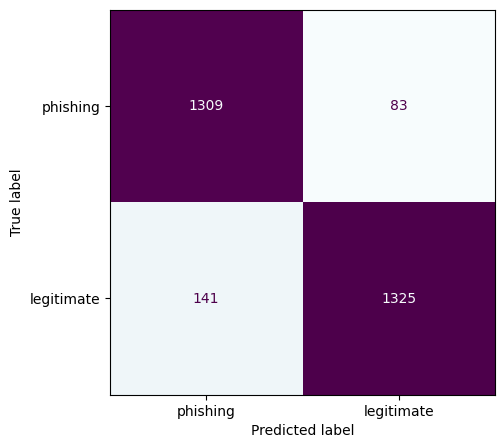

In [ ]:
# classification report

clf_report = classification_report(pred, y_test, target_names = list(classes.values()))
print(clf_report)
# Generate confusion matrix and plot it
cm = confusion_matrix(y_test, pred)
# Changed 'display_statuss' to the correct argument 'display_labels'
cmd = ConfusionMatrixDisplay(cm, display_labels=list(classes.values()))

fig, ax = plt.subplots(figsize=(5, 5))
cmd.plot(ax=ax, cmap='BuPu', colorbar=False)

In [ ]:
# Define GA hyperparameters
size = 100  # Population size
n_feat = X_train.shape[1]  # Number of features
n_parents = 50  # Number of parents to select
mutation_rate = 0.1  # Mutation rate
n_gen = 100  # Number of generations

In [ ]:
# Function for initialization of population in GA
def initialization_of_population(size, n_feat):
    population = []
    for i in range(size):
        chromosome = np.ones(n_feat, dtype=bool)
        chromosome[:int(0.3 * n_feat)] = False
        np.random.shuffle(chromosome)
        population.append(chromosome)
    return population

In [ ]:
def fitness_score(population):
    scores = []
    for chromosome in population:
        model.fit(X_train[:, chromosome], y_train)
        predictions = model.predict(X_test[:, chromosome])
        scores.append(accuracy_score(y_test, predictions))
    scores, population = np.array(scores), np.array(population)
    inds = np.argsort(scores)
    return list(scores[inds][::-1]), list(population[inds, :][::-1])

In [ ]:
# Function for selection in GA
def selection(pop_after_fit, n_parents):
    population_nextgen = []
    for i in range(n_parents):
        population_nextgen.append(pop_after_fit[i])
    return population_nextgen

In [ ]:
# Function for crossover in GA
def crossover(pop_after_sel):
    pop_nextgen = pop_after_sel
    for i in range(0, len(pop_after_sel), 2):
        new_par = []
        child_1, child_2 = pop_nextgen[i], pop_nextgen[i + 1]
        new_par = np.concatenate((child_1[:len(child_1) // 2], child_2[len(child_1) // 2:]))
        pop_nextgen.append(new_par)
    return pop_nextgen

In [ ]:
# Function for mutation in GA
def mutation(pop_after_cross, mutation_rate, n_feat):
    mutation_range = int(mutation_rate * n_feat)
    pop_next_gen = []
    for n in range(0, len(pop_after_cross)):
        chromo = pop_after_cross[n]
        rand_posi = []
        for i in range(0, mutation_range):
            pos = np.random.randint(0, n_feat - 1)
            rand_posi.append(pos)
        for j in rand_posi:
            chromo[j] = not chromo[j]
        pop_next_gen.append(chromo)
    return pop_next_gen

In [ ]:
# Function for GA generations
def generations(size, n_feat, n_parents, mutation_rate, n_gen, X_train, X_test, y_train, y_test):
    best_chromo = []
    best_score = []
    population_nextgen = initialization_of_population(size, n_feat)
    for i in range(n_gen):
        scores, pop_after_fit = fitness_score(population_nextgen)
        print('Best score in generation', i + 1, ':', scores[:1])  # Print best score in each generation
        pop_after_sel = selection(pop_after_fit, n_parents)
        pop_after_cross = crossover(pop_after_sel)
        population_nextgen = mutation(pop_after_cross, mutation_rate, n_feat)
        best_chromo.append(pop_after_fit[0])
        best_score.append(scores[0])
    return best_chromo, best_score

In [ ]:
# Run GA after hyperparameter optimization
best_chromo, best_score = generations(size, n_feat, n_parents, mutation_rate, n_gen,
                                                               X_train, X_test, y_train, y_test)

Best score in generation 1 : [np.float64(0.9289713086074177)]
Best score in generation 2 : [np.float64(0.9317704688593422)]
Best score in generation 3 : [np.float64(0.93037088873338)]
Best score in generation 4 : [np.float64(0.9342197340797761)]
Best score in generation 5 : [np.float64(0.9331700489853044)]
Best score in generation 6 : [np.float64(0.9356193142057383)]
Best score in generation 7 : [np.float64(0.9363191042687193)]
Best score in generation 8 : [np.float64(0.937368789363191)]
Best score in generation 9 : [np.float64(0.9387683694891532)]
Best score in generation 10 : [np.float64(0.9352694191742478)]
Best score in generation 11 : [np.float64(0.9380685794261722)]
Best score in generation 12 : [np.float64(0.9359692092372288)]
Best score in generation 13 : [np.float64(0.93666899930021)]
Best score in generation 14 : [np.float64(0.9391182645206438)]
Best score in generation 15 : [np.float64(0.9394681595521344)]
Best score in generation 16 : [np.float64(0.9412176347095871)]
Best s

In [ ]:
# Get the best chromosome
best_chromosome = best_chromo[-1]

# Filter features based on the best chromosome
selected_features = X.columns[best_chromosome]

print("Best features selected by GA:")
print(selected_features)


Best features selected by GA:
Index(['url', 'length_hostname', 'ip', 'nb_hyphens', 'nb_at', 'nb_qm',
       'nb_and', 'nb_or', 'nb_underscore', 'nb_colon', 'nb_semicolumn',
       'nb_dollar', 'nb_www', 'ratio_digits_url', 'tld_in_subdomain',
       'path_extension', 'nb_redirection', 'nb_external_redirection',
       'char_repeat', 'shortest_word_host', 'shortest_word_path',
       'longest_word_host', 'avg_word_path', 'phish_hints',
       'brand_in_subdomain', 'nb_hyperlinks', 'ratio_extHyperlinks',
       'ratio_intErrors', 'ratio_extErrors', 'submit_email', 'iframe',
       'safe_anchor', 'empty_title', 'domain_in_title', 'google_index',
       'page_rank'],
      dtype='object')


In [ ]:
# Select only the best features for training
X_train_ga = X_train[:, best_chromosome]
X_test_ga = X_test[:, best_chromosome]

# Initialize and train SVM model using the best features selected by GA
model_ga = KNeighborsClassifier(n_neighbors=5)  # You can adjust n_neighbors
model_ga.fit(X_train_ga, y_train)


KNeighborsClassifier()

In [ ]:

# Make predictions
pred_ga = model_ga.predict(X_test_ga)

# Evaluate the model
acc_ga = accuracy_score(y_test, pred_ga)
print('Accuracy Score using selected features by GA: {0:.2f} %'.format(acc_ga * 100))

# Classification report
clf_report_ga = classification_report(y_test, pred_ga, target_names=list(classes.values()))
print("Classification Report using selected features by GA:")
print(clf_report_ga)

Accuracy Score using selected features by GA: 94.23 %
Classification Report using selected features by GA:
              precision    recall  f1-score   support

    phishing       0.92      0.96      0.94      1392
  legitimate       0.96      0.92      0.94      1466

    accuracy                           0.94      2858
   macro avg       0.94      0.94      0.94      2858
weighted avg       0.94      0.94      0.94      2858



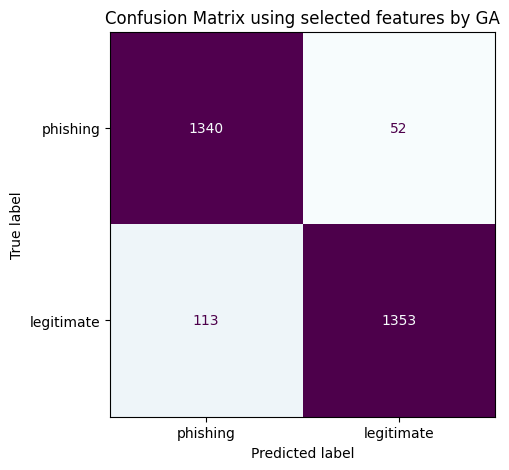

In [ ]:
# Generate confusion matrix and plot it
cm_ga = confusion_matrix(y_test, pred_ga)
# Changed 'display_statuss' to the correct argument 'display_labels'
cmd_ga = ConfusionMatrixDisplay(cm_ga, display_labels=list(classes.values()))

fig, ax = plt.subplots(figsize=(5, 5))
cmd_ga.plot(ax=ax, cmap='BuPu', colorbar=False)
plt.title("Confusion Matrix using selected features by GA")
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score

# PSO parameters
n_particles = 30       # Number of particles in the swarm
n_iterations = 50      # Number of iterations (generations)
n_features = X_train.shape[1]  # Number of features

w = 0.5                # Inertia weight
c1 = 1.5               # Cognitive component (personal best influence)
c2 = 1.5               # Social component (global best influence)

# Set random seed for reproducibility
np.random.seed(SEED)

# Initialize particles and velocities
particles = np.random.rand(n_particles, n_features)      # Positions (values between 0 and 1)
velocities = np.random.rand(n_particles, n_features)     # Velocities

# Initialize personal best positions and scores
personal_best_positions = particles.copy()
personal_best_scores = np.zeros(n_particles)

# Evaluate initial particles
for i in range(n_particles):
    selected = particles[i] > 0.5  # Binary mask for selected features
    if np.sum(selected) == 0:      # If no feature selected
        personal_best_scores[i] = 0
    else:

        model.fit(X_train[:, selected], y_train)
        preds = model.predict(X_test[:, selected])
        personal_best_scores[i] = accuracy_score(y_test, preds)

# Find the global best particle
global_best_idx = np.argmax(personal_best_scores)
global_best_position = personal_best_positions[global_best_idx].copy()

# PSO main loop
for iteration in range(n_iterations):
    for i in range(n_particles):
        # Generate random numbers for velocity update
        r1 = np.random.rand(n_features)
        r2 = np.random.rand(n_features)

        # Update velocity based on personal and global bests
        velocities[i] = (
            w * velocities[i]
            + c1 * r1 * (personal_best_positions[i] - particles[i])
            + c2 * r2 * (global_best_position - particles[i])
        )

        # Update particle position and clip to [0, 1]
        particles[i] += velocities[i]
        particles[i] = np.clip(particles[i], 0, 1)

        # Evaluate new position
        selected = particles[i] > 0.5
        if np.sum(selected) == 0:
            score = 0
        else:
            model = KNeighborsClassifier(n_neighbors=5)
            model.fit(X_train[:, selected], y_train)
            preds = model.predict(X_test[:, selected])
            score = accuracy_score(y_test, preds)

        # Update personal best if current score is better
        if score > personal_best_scores[i]:
            personal_best_scores[i] = score
            personal_best_positions[i] = particles[i].copy()

    # Update global best
    global_best_idx = np.argmax(personal_best_scores)
    global_best_position = personal_best_positions[global_best_idx].copy()

    print(f"Iteration {iteration+1}/{n_iterations}, Best Accuracy: {personal_best_scores[global_best_idx]:.4f}")

# Get the best feature subset from the final global best particle
best_features_mask = global_best_position > 0.5
selected_features = X.columns[best_features_mask]
print("Best features selected by PSO:")
print(selected_features)

# Train final model using selected features
X_train_pso = X_train[:, best_features_mask]
X_test_pso = X_test[:, best_features_mask]

final_model = KNeighborsClassifier(n_neighbors=5)
final_model.fit(X_train_pso, y_train)
pred_pso = final_model.predict(X_test_pso)
acc_pso = accuracy_score(y_test, pred_pso)

print("Accuracy using PSO-selected features: {:.2f}%".format(acc_pso * 100))


Iteration 1/50, Best Accuracy: 0.9262
Iteration 2/50, Best Accuracy: 0.9262
Iteration 3/50, Best Accuracy: 0.9265
Iteration 4/50, Best Accuracy: 0.9286
Iteration 5/50, Best Accuracy: 0.9286
Iteration 6/50, Best Accuracy: 0.9293
Iteration 7/50, Best Accuracy: 0.9300
Iteration 8/50, Best Accuracy: 0.9307
Iteration 9/50, Best Accuracy: 0.9321
Iteration 10/50, Best Accuracy: 0.9321
Iteration 11/50, Best Accuracy: 0.9321
Iteration 12/50, Best Accuracy: 0.9325
Iteration 13/50, Best Accuracy: 0.9328
Iteration 14/50, Best Accuracy: 0.9328
Iteration 15/50, Best Accuracy: 0.9328
Iteration 16/50, Best Accuracy: 0.9328
Iteration 17/50, Best Accuracy: 0.9328
Iteration 18/50, Best Accuracy: 0.9328
Iteration 19/50, Best Accuracy: 0.9328
Iteration 20/50, Best Accuracy: 0.9328
Iteration 21/50, Best Accuracy: 0.9328
Iteration 22/50, Best Accuracy: 0.9328
Iteration 23/50, Best Accuracy: 0.9328
Iteration 24/50, Best Accuracy: 0.9328
Iteration 25/50, Best Accuracy: 0.9328
Iteration 26/50, Best Accuracy: 0.

In [ ]:

# Generate classification report
print("\nClassification Report after using PSO:")
print(classification_report(y_test, pred_pso))


Classification Report after using PSO:
              precision    recall  f1-score   support

  legitimate       0.91      0.95      0.93      1392
    phishing       0.95      0.91      0.93      1466

    accuracy                           0.93      2858
   macro avg       0.93      0.93      0.93      2858
weighted avg       0.93      0.93      0.93      2858




Confusion Matrix:
[[1327   65]
 [ 127 1339]]


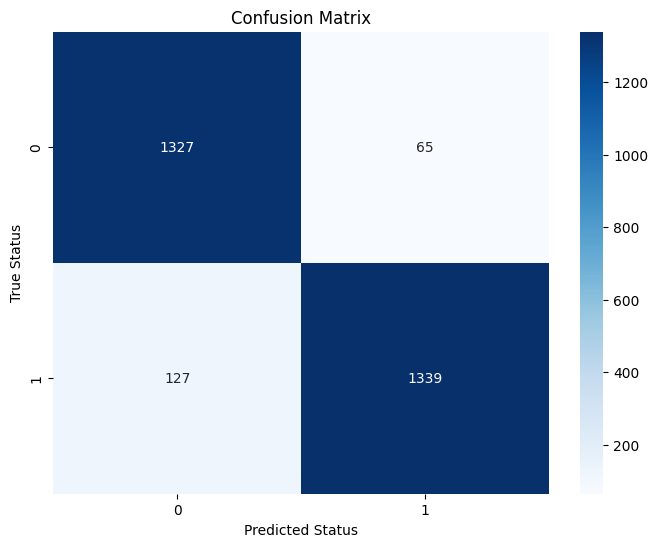

In [ ]:
# Generate confusion matrix
cm = confusion_matrix(y_test, pred_pso)
print("\nConfusion Matrix:")
print(cm)

# Plot confusion matrix (optional, requires matplotlib and seaborn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Status") # Corrected from xstatus
plt.ylabel("True Status")     # Corrected from ystatus
plt.show()

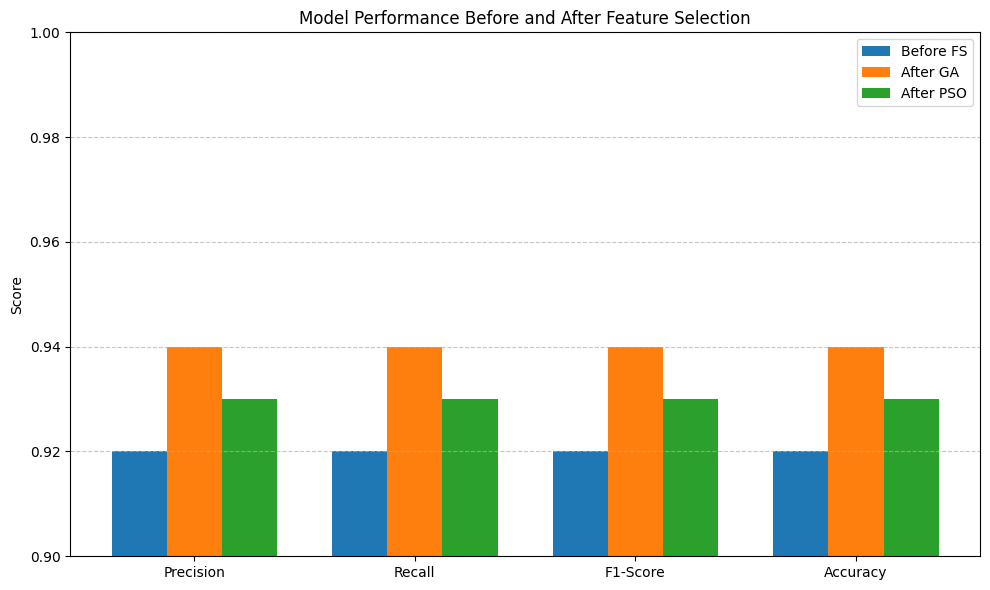

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define the metrics
metrics = ['Precision', 'Recall', 'F1-Score', 'Accuracy'] # Renamed from statuss

before = [0.92, 0.92, 0.92, 0.92]  # Macro avg + accuracy
ga     = [0.94, 0.94, 0.94, 0.94]
pso    = [0.93, 0.93, 0.93, 0.93]

# Bar width and x locations
x = np.arange(len(metrics))
width = 0.25

# Create plot
plt.figure(figsize=(10, 6))
# Changed 'status' to 'label'
plt.bar(x - width, before, width, label='Before FS', color='#1f77b4')
# Changed 'status' to 'label'
plt.bar(x, ga, width, label='After GA', color='#ff7f0e')
# Changed 'status' to 'label'
plt.bar(x + width, pso, width, label='After PSO', color='#2ca02c')

# labels and formatting
plt.ylabel('Score') # Changed from plt.ystatus
plt.ylim(0.90, 1.0)
plt.title('Model Performance Before and After Feature Selection')
plt.xticks(x, metrics) # Used the renamed variable
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


----- Evaluation using All features -----

KNN:
              precision    recall  f1-score   support

    phishing       0.90      0.94      0.92      1392
  legitimate       0.94      0.90      0.92      1466

    accuracy                           0.92      2858
   macro avg       0.92      0.92      0.92      2858
weighted avg       0.92      0.92      0.92      2858


SVM:
              precision    recall  f1-score   support

    phishing       0.93      0.97      0.95      1392
  legitimate       0.97      0.94      0.95      1466

    accuracy                           0.95      2858
   macro avg       0.95      0.95      0.95      2858
weighted avg       0.95      0.95      0.95      2858


Random Forest:
              precision    recall  f1-score   support

    phishing       0.96      0.97      0.96      1392
  legitimate       0.97      0.96      0.97      1466

    accuracy                           0.96      2858
   macro avg       0.96      0.96      0.96      2858
wei

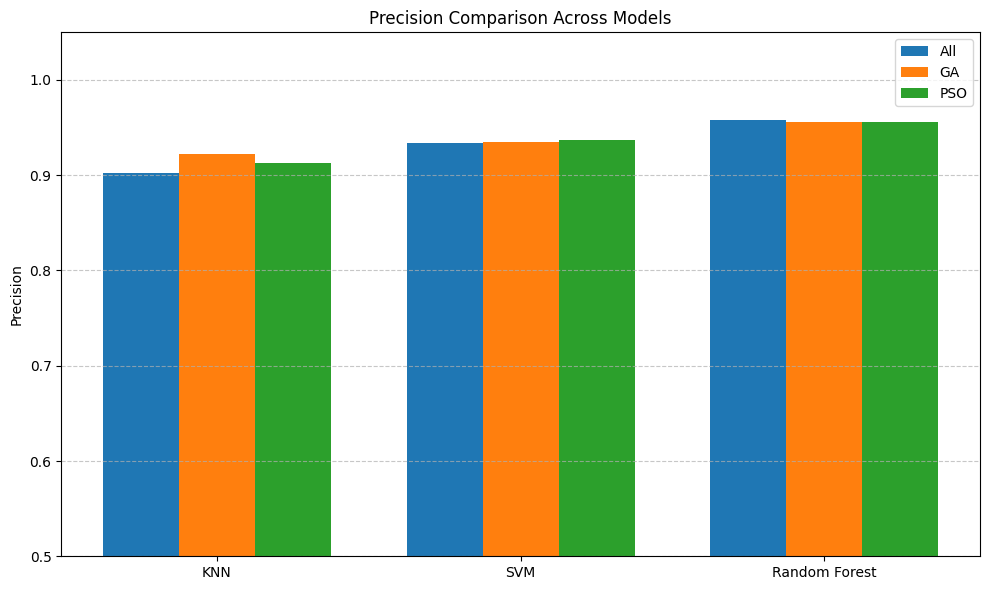

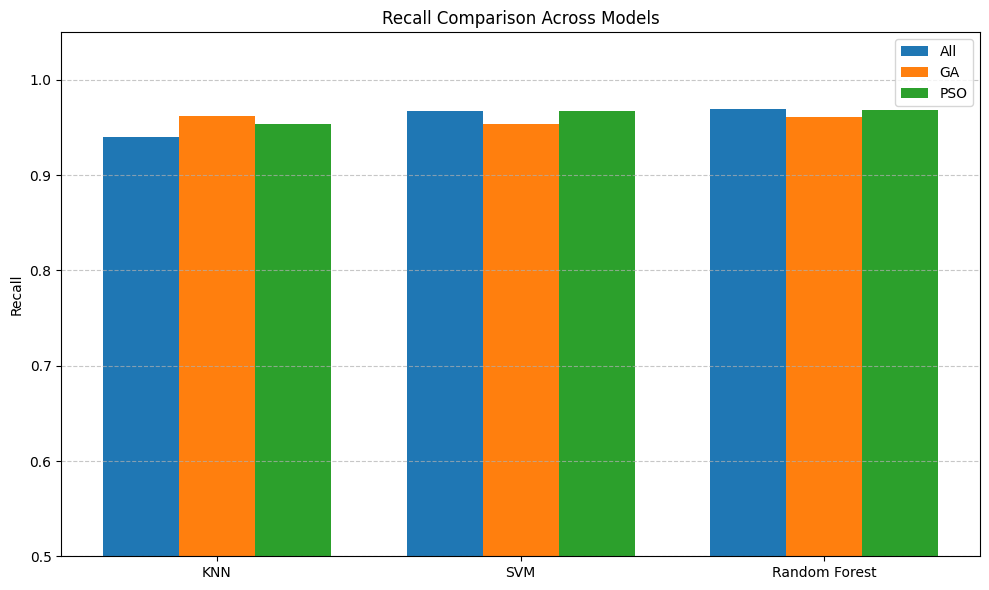

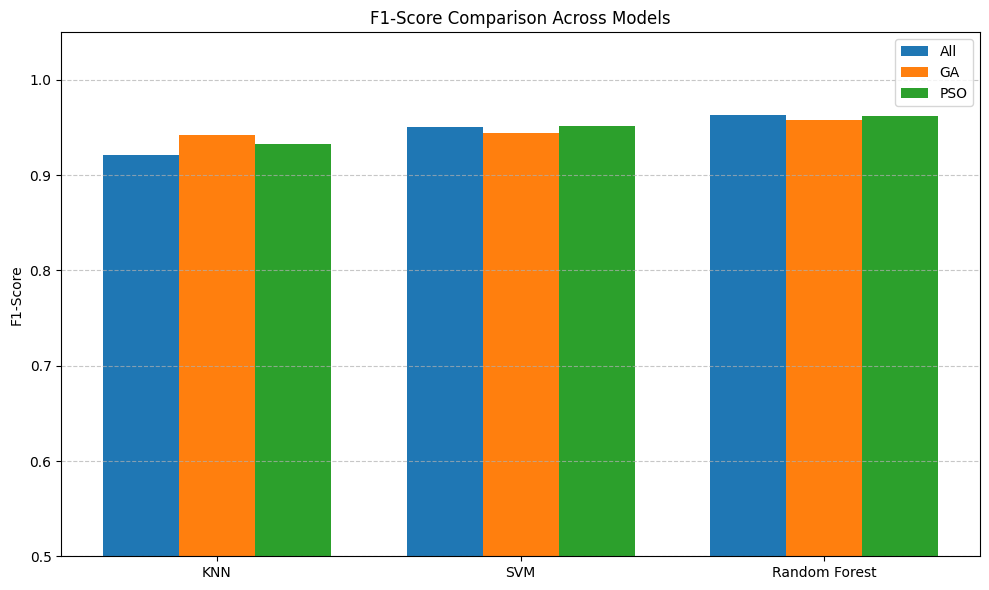

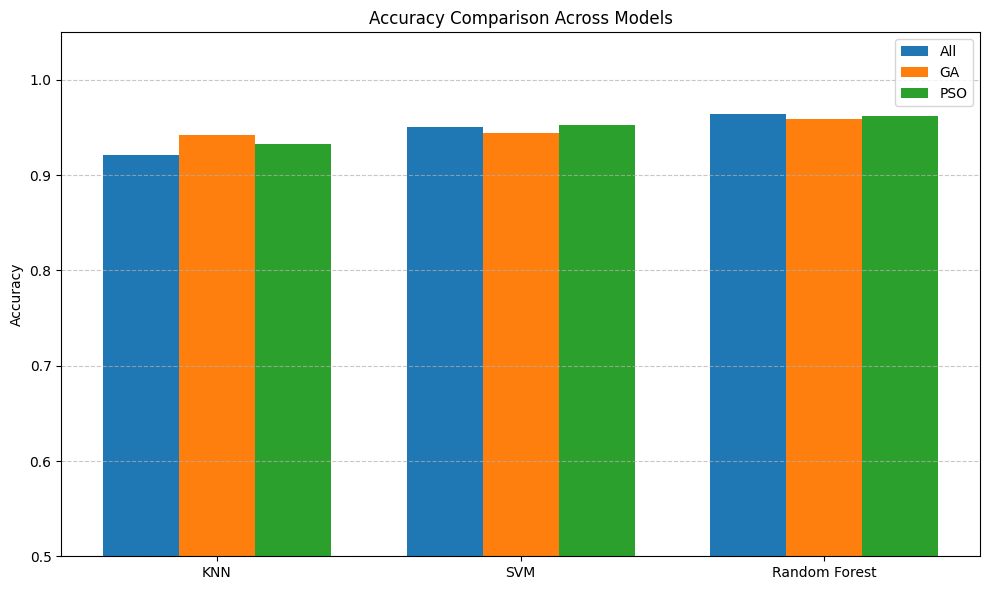

In [ ]:
# Additional classifiers evaluation BEFORE GA and PSO feature selection
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

# Define classifiers
models = {
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "SVM": SVC(),
    "Random Forest": RandomForestClassifier(random_state=SEED)
}

# Evaluation function
results = {"All": {}, "GA": {}, "PSO": {}}

def evaluate_models(X_train_fs, X_test_fs, y_train, y_test, fs_name=""):
    print(f"\n----- Evaluation using {fs_name} features -----")
    for name, model in models.items():
        model.fit(X_train_fs, y_train)
        y_pred = model.predict(X_test_fs)
        print(f"\n{name}:")
        print(classification_report(y_test, y_pred, target_names=list(classes.values())))

        # Collect metrics for plotting
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, pos_label='legitimate')
        rec = recall_score(y_test, y_pred, pos_label='legitimate')
        f1 = f1_score(y_test, y_pred, pos_label='legitimate')
        results[fs_name][name] = [prec, rec, f1, acc]

# Evaluation BEFORE Feature Selection
evaluate_models(X_train, X_test, y_train, y_test, fs_name="All")

# Evaluation using GA-selected features
evaluate_models(X_train_ga, X_test_ga, y_train, y_test, fs_name="GA")

# Evaluation using PSO-selected features
evaluate_models(X_train_pso, X_test_pso, y_train, y_test, fs_name="PSO")

# Plotting the results as bar charts
metrics = ['Precision', 'Recall', 'F1-Score', 'Accuracy']
fs_methods = ['All', 'GA', 'PSO']

for metric_idx, metric_name in enumerate(metrics):
    plt.figure(figsize=(10, 6))
    x = np.arange(len(models))  # Model index
    width = 0.25

    for i, fs in enumerate(fs_methods):
        scores = [results[fs][model][metric_idx] for model in models.keys()]
        plt.bar(x + (i - 1) * width, scores, width=width, label=fs)

    plt.title(f'{metric_name} Comparison Across Models')
    plt.xticks(x, models.keys())
    plt.ylabel(metric_name)
    plt.ylim(0.5, 1.05)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.show()